# Model Summary + Validation

## Original Model
- **Arrivals**
  - Walk‑ins arrive directly to **ER, SURG, ICU, SD**.
  - Ambulances arrive to **ER only**.
- **Diversion Rule**
  - Ambulances are diverted **only if** ER already has a waiting queue **and** ER is full.
- **Decision Variables**
  - Admissions into each department.
  - Transfers between departments.
  - Temporary staff.
  - Ambulance admit vs divert.
- **Constraints**
  - Flow balance each hour.
  - Bed capacity per department.
  - 1:1 staff‑to‑patient ratio (permanent + temp).
  - Ready‑out limits per hour.
- **Objective**
  - Minimize waiting cost + temp staff cost + diversion cost.

---

## Optimized Model (Triage‑Based)
- **Arrivals**
  - All walk‑ins go to **Triage**.
  - Ambulances still go to **ER**.
- **Triage Split**
  - 50% low acuity → **Step Down**
  - 25% high acuity → **ER**
  - 25% high acuity → **direct ICU/Surgery**
- **Triage Capacity**
  - Triage has limited beds (25)
  - Excess walk‑ins stay in triage waiting.
- **Triage Staffing**
  - Triage has **permanent staff** (e.g., 7).
  - Temp staff covers demand above that capacity.
- **Other Constraints**
  - Admissions capped per hour by department.
  - ER can double‑bunk (capacity 2× rooms) with penalty.
  - Same flow balance and staffing constraints as original.
- **Objective**
  - Minimize waiting cost + temp staff cost + triage wait cost + triage staffing cost + double‑bunk penalty.

---

## Validation Tests (Sanity Checks)
The validation block is **not proving optimality**. It just checks basic sanity:

- **Non‑negativity:** no negative patients, waiting, or temp staff.
- **Capacity:** patients never exceed room capacity (ER can be 2× in optimized).
- **Costs:** total costs are non‑negative.

If any check fails, it raises an error immediately so you can catch a bug or modeling mistake.


Original total cost: 10437880
Optimized total cost: 6909090
Avg triage temp staff: 0.041666666666666664
Total triage temp staff (sum over 24h): 1


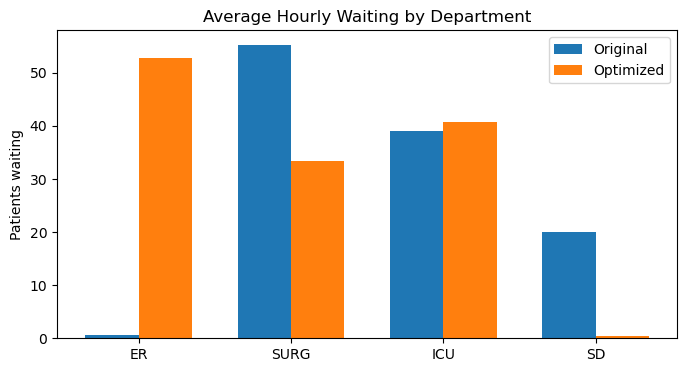

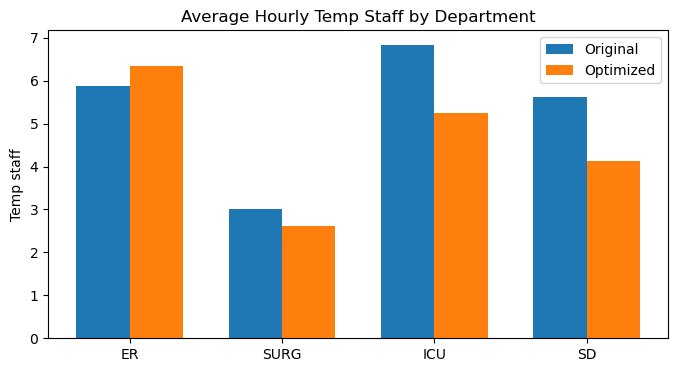

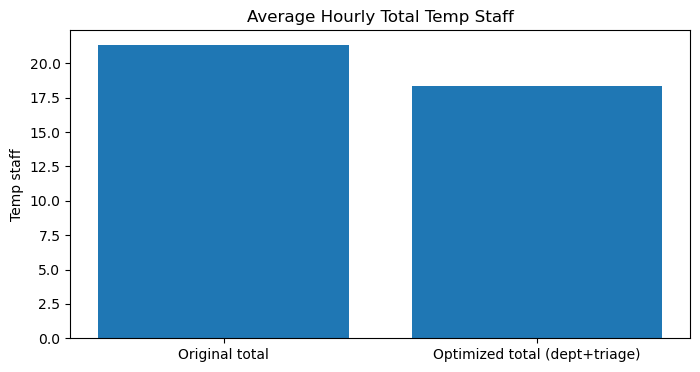

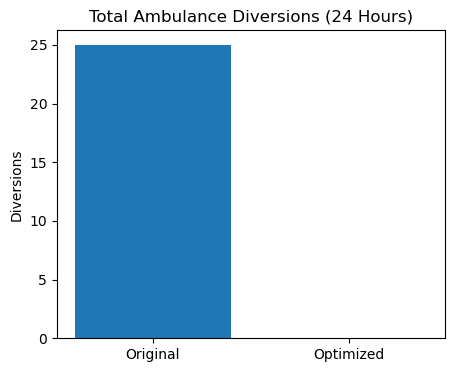

In [58]:
import numpy as np
from collections import defaultdict
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# -----------------------------
# COMMON SETTINGS
# -----------------------------
T = 24
hours = list(range(1, T + 1))
DEPTS = ["ER", "SURG", "ICU", "SD"]

rooms = {"ER": 25, "SURG": 9, "ICU": 20, "SD": 30}
staff_perm = {"ER": 18, "SURG": 6, "ICU": 13, "SD": 24}
init_patients = {"ER": 16, "SURG": 4, "ICU": 12, "SD": 22}
init_wait = {"ER": 0, "SURG": 0, "ICU": 0, "SD": 0}

cost_wait = {"ER": 150, "SURG": 3750, "ICU": 3750, "SD": 3750}
cost_ambulance_divert = 5000
cost_temp_staff = 40

ready_out_mean = {"ER": 6.0, "SURG": 1.0, "ICU": 1.0, "SD": 4.0}

TRANSITIONS = [
    ("ER", "SURG"),
    ("ER", "ICU"),
    ("ER", "SD"),
    ("ER", "DISCH"),
    ("SURG", "ICU"),
    ("SURG", "SD"),
    ("ICU", "SD"),
    ("SD", "DISCH"),
]

# -----------------------------
# FIXED ARRIVALS (24 HOURS)
# -----------------------------
sample_arrivals = {
    "ER_walkin":  [5,6,4,7,5,6,5,4,6,7,5,6,5,4,6,7,5,6,5,4,6,7,5,6],
    "SURG_walkin":[5,4,6,5,5,4,6,5,4,5,6,4,5,6,5,4,6,5,4,6,5,4,6,5],
    "ICU_walkin": [4,3,4,3,5,4,3,4,3,4,3,4,5,3,4,3,4,3,4,3,4,3,4,3],
    "SD_walkin":  [6,7,6,5,5,6,6,7,7,6,6,7,5,7,6,7,5,6,7,7,6,7,5,6],
    "ER_ambulance":[2,1,3,2,2,1,2,3,2,2,1,2,3,2,1,2,3,2,2,1,2,3,2,1],
}

def get_arrivals(hour_idx):
    return {
        "ER_walkin": sample_arrivals["ER_walkin"][hour_idx],
        "SURG_walkin": sample_arrivals["SURG_walkin"][hour_idx],
        "ICU_walkin": sample_arrivals["ICU_walkin"][hour_idx],
        "SD_walkin": sample_arrivals["SD_walkin"][hour_idx],
        "ER_ambulance": sample_arrivals["ER_ambulance"][hour_idx],
    }

# -----------------------------
# MODEL 1: ORIGINAL
# -----------------------------
def run_original():
    patients = init_patients.copy()
    waiting = init_wait.copy()

    history = {
        "patients": defaultdict(list),
        "waiting": defaultdict(list),
        "temp_staff": defaultdict(list),
        "amb_divert": [],
    }

    summary = {"ambulance_diverted": 0, "cost_wait": 0, "cost_divert": 0, "cost_temp": 0}

    for t in hours:
        a = get_arrivals(t-1)
        arr_walk = {
            "ER": a["ER_walkin"],
            "SURG": a["SURG_walkin"],
            "ICU": a["ICU_walkin"],
            "SD": a["SD_walkin"],
        }
        arr_amb = a["ER_ambulance"]

        if waiting["ER"] > 0 and patients["ER"] >= rooms["ER"]:
            amb_forced_divert = arr_amb
            arr_amb = 0
        else:
            amb_forced_divert = 0

        ready_out = {d: int(round(ready_out_mean[d])) for d in DEPTS}

        m = gp.Model(f"orig_{t}")
        m.Params.OutputFlag = 0

        flow = m.addVars(TRANSITIONS, vtype=GRB.INTEGER, lb=0, name="flow")
        admit = m.addVars(DEPTS, vtype=GRB.INTEGER, lb=0, name="admit")
        temp_staff = m.addVars(DEPTS, vtype=GRB.INTEGER, lb=0, name="temp_staff")
        amb_admit = m.addVar(vtype=GRB.INTEGER, lb=0, name="amb_admit")
        amb_divert = m.addVar(vtype=GRB.INTEGER, lb=0, name="amb_divert")

        m.addConstr(amb_admit + amb_divert == arr_amb)
        m.addConstr(admit["ER"] <= waiting["ER"] + arr_walk["ER"] + amb_admit)

        for d in ["SURG","ICU","SD"]:
            m.addConstr(admit[d] <= waiting[d] + arr_walk[d])

        for d in DEPTS:
            inflow = gp.LinExpr()
            outflow = gp.LinExpr()
            for (i,j) in TRANSITIONS:
                if j == d: inflow += flow[i,j]
                if i == d: outflow += flow[i,j]

            end_patients = patients[d] + admit[d] + inflow - outflow
            m.addConstr(outflow <= ready_out[d])
            m.addConstr(end_patients <= rooms[d])
            m.addConstr(end_patients <= staff_perm[d] + temp_staff[d])

        obj = gp.LinExpr()
        for d in DEPTS:
            if d == "ER":
                end_wait = waiting[d] + arr_walk["ER"] + amb_admit - admit[d]
            else:
                end_wait = waiting[d] + arr_walk[d] - admit[d]
            obj += cost_wait[d] * end_wait
            obj += cost_temp_staff * temp_staff[d]
        obj += cost_ambulance_divert * amb_divert

        m.setObjective(obj, GRB.MINIMIZE)
        m.optimize()

        for d in DEPTS:
            inflow = sum(flow[i,j].X for (i,j) in TRANSITIONS if j == d)
            outflow = sum(flow[i,j].X for (i,j) in TRANSITIONS if i == d)
            patients[d] = int(patients[d] + admit[d].X + inflow - outflow)

            if d == "ER":
                waiting[d] = int(waiting[d] + arr_walk["ER"] + amb_admit.X - admit[d].X)
            else:
                waiting[d] = int(waiting[d] + arr_walk[d] - admit[d].X)

            history["patients"][d].append(patients[d])
            history["waiting"][d].append(waiting[d])
            history["temp_staff"][d].append(int(temp_staff[d].X))

        total_divert = int(amb_divert.X) + amb_forced_divert
        history["amb_divert"].append(total_divert)
        summary["ambulance_diverted"] += total_divert

        for d in DEPTS:
            summary["cost_wait"] += cost_wait[d] * waiting[d]
            summary["cost_temp"] += cost_temp_staff * int(temp_staff[d].X)
        summary["cost_divert"] += cost_ambulance_divert * total_divert

    total_cost = summary["cost_wait"] + summary["cost_temp"] + summary["cost_divert"]
    return total_cost, summary, history

# -----------------------------
# MODEL 2: OPTIMIZED
# -----------------------------
def run_optimized():
    triage_perm = 7
    frac_low = 0.50
    frac_high_to_er = 0.25
    frac_high_direct = 0.25

    triage_penalty = 50
    double_bunk_penalty = 500
    triage_wait_cost = 200

    triage_beds = 25
    triage_staff_ratio = 3
    triage_temp_cost = 40

    max_admit = {"ER": 8, "SURG": 1, "ICU": 1, "SD": 4}
    staff_ratio = {"ER": 1, "SURG": 1, "ICU": 1, "SD": 1}

    patients = init_patients.copy()
    waiting = init_wait.copy()
    triage_inbed = 0
    triage_wait = 0

    history = {
        "patients": defaultdict(list),
        "waiting": defaultdict(list),
        "temp_staff": defaultdict(list),
        "triage_wait": [],
        "triage_inbed": [],
        "triage_temp": [],
    }

    summary = {"cost_wait": 0, "cost_temp": 0, "cost_double_bunk": 0,
               "cost_triage_wait": 0, "cost_triage_temp": 0}

    for t in hours:
        a = get_arrivals(t-1)
        arr_walk = {
            "ER": a["ER_walkin"],
            "SURG": a["SURG_walkin"],
            "ICU": a["ICU_walkin"],
            "SD": a["SD_walkin"],
        }
        arr_amb = a["ER_ambulance"]

        total_walkins = arr_walk["ER"] + arr_walk["SURG"] + arr_walk["ICU"] + arr_walk["SD"]

        triage_free = triage_beds - triage_inbed
        move_from_wait = min(triage_free, triage_wait)
        triage_inbed += move_from_wait
        triage_wait -= move_from_wait

        triage_free = triage_beds - triage_inbed
        add_to_bed = min(triage_free, total_walkins)
        triage_inbed += add_to_bed
        triage_wait += (total_walkins - add_to_bed)

        ready_out = {d: int(round(ready_out_mean[d])) for d in DEPTS}

        m = gp.Model(f"opt_{t}")
        m.Params.OutputFlag = 0

        flow = m.addVars(TRANSITIONS, vtype=GRB.INTEGER, lb=0, name="flow")
        admit = m.addVars(DEPTS, vtype=GRB.INTEGER, lb=0, name="admit")
        temp_staff = m.addVars(DEPTS, vtype=GRB.INTEGER, lb=0, name="temp_staff")
        triage_temp = m.addVar(vtype=GRB.INTEGER, lb=0, name="triage_temp")

        triage_ready = triage_inbed
        low = m.addVar(vtype=GRB.INTEGER, lb=0, name="low")
        high_er = m.addVar(vtype=GRB.INTEGER, lb=0, name="high_er")
        high_direct = m.addVar(vtype=GRB.INTEGER, lb=0, name="high_direct")
        m.addConstr(low + high_er + high_direct == triage_ready)

        dev = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="triage_dev")
        m.addConstr(low - frac_low * triage_ready <= dev)
        m.addConstr(frac_low * triage_ready - low <= dev)
        m.addConstr(high_er - frac_high_to_er * triage_ready <= dev)
        m.addConstr(frac_high_to_er * triage_ready - high_er <= dev)
        m.addConstr(high_direct - frac_high_direct * triage_ready <= dev)
        m.addConstr(frac_high_direct * triage_ready - high_direct <= dev)

        walk_to_sd = m.addVar(vtype=GRB.INTEGER, lb=0, name="walk_to_sd")
        m.addConstr(walk_to_sd == low)

        high_er_to_er = m.addVar(vtype=GRB.INTEGER, lb=0, name="high_er_to_er")
        high_er_to_direct = m.addVar(vtype=GRB.INTEGER, lb=0, name="high_er_to_direct")
        m.addConstr(high_er_to_er + high_er_to_direct == high_er)
        m.addConstr(2 * high_er_to_er >= high_er)
        m.addConstr(2 * high_er_to_er <= high_er + 1)

        walk_to_er = high_er_to_er
        total_direct = high_direct + high_er_to_direct

        walk_to_icu = m.addVar(vtype=GRB.INTEGER, lb=0, name="walk_to_icu")
        walk_to_surg = m.addVar(vtype=GRB.INTEGER, lb=0, name="walk_to_surg")
        m.addConstr(walk_to_icu + walk_to_surg == total_direct)
        m.addConstr(2 * walk_to_icu >= total_direct)
        m.addConstr(2 * walk_to_icu <= total_direct + 1)

        m.addConstr(admit["ER"] <= waiting["ER"] + arr_amb + walk_to_er)
        for d in DEPTS:
            m.addConstr(admit[d] <= max_admit[d])

        m.addConstr(admit["SD"] <= waiting["SD"] + walk_to_sd)
        m.addConstr(admit["ICU"] <= waiting["ICU"] + walk_to_icu)
        m.addConstr(admit["SURG"] <= waiting["SURG"] + walk_to_surg)

        for d in DEPTS:
            inflow = gp.LinExpr()
            outflow = gp.LinExpr()
            for (i,j) in TRANSITIONS:
                if j == d: inflow += flow[i,j]
                if i == d: outflow += flow[i,j]

            end_patients = patients[d] + admit[d] + inflow - outflow
            m.addConstr(outflow <= ready_out[d])
            if d == "ER":
                m.addConstr(end_patients <= rooms[d] * 2)
            else:
                m.addConstr(end_patients <= rooms[d])
            m.addConstr(end_patients * staff_ratio[d] <= staff_perm[d] + temp_staff[d])

        # FIXED triage staffing (perm staff is staff capacity, not patients)
        triage_need = m.addVar(vtype=GRB.INTEGER, lb=0, name="triage_need")
        m.addConstr(triage_need >= (triage_inbed + triage_wait) - triage_perm * triage_staff_ratio)
        m.addConstr(triage_staff_ratio * triage_temp >= triage_need, name="triage_staffing")

        obj = gp.LinExpr()
        for d in DEPTS:
            if d == "ER":
                end_wait = waiting[d] + arr_amb + walk_to_er - admit[d]
            elif d == "SD":
                end_wait = waiting[d] + walk_to_sd - admit[d]
            elif d == "ICU":
                end_wait = waiting[d] + walk_to_icu - admit[d]
            elif d == "SURG":
                end_wait = waiting[d] + walk_to_surg - admit[d]
            obj += cost_wait[d] * end_wait
            obj += cost_temp_staff * temp_staff[d]

        obj += triage_wait_cost * triage_wait
        obj += triage_temp_cost * triage_temp
        obj += triage_penalty * dev

        er_crowd = m.addVar(vtype=GRB.INTEGER, lb=0)
        inflow_er = gp.quicksum(flow[i,j] for (i,j) in TRANSITIONS if j == "ER")
        outflow_er = gp.quicksum(flow[i,j] for (i,j) in TRANSITIONS if i == "ER")
        end_er = patients["ER"] + admit["ER"] + inflow_er - outflow_er
        m.addConstr(end_er - 25 <= er_crowd)
        obj += double_bunk_penalty * er_crowd

        m.setObjective(obj, GRB.MINIMIZE)
        m.optimize()

        for d in DEPTS:
            inflow = sum(flow[i,j].X for (i,j) in TRANSITIONS if j == d)
            outflow = sum(flow[i,j].X for (i,j) in TRANSITIONS if i == d)
            patients[d] = int(patients[d] + admit[d].X + inflow - outflow)

            if d == "ER":
                waiting[d] = int(waiting[d] + arr_amb + walk_to_er.X - admit[d].X)
            elif d == "SD":
                waiting[d] = int(waiting[d] + walk_to_sd.X - admit[d].X)
            elif d == "ICU":
                waiting[d] = int(waiting[d] + walk_to_icu.X - admit[d].X)
            elif d == "SURG":
                waiting[d] = int(waiting[d] + walk_to_surg.X - admit[d].X)

            history["patients"][d].append(patients[d])
            history["waiting"][d].append(waiting[d])
            history["temp_staff"][d].append(int(temp_staff[d].X))

        triage_out = int(low.X + high_er.X + high_direct.X)
        triage_inbed = max(triage_inbed - triage_out, 0)
        history["triage_inbed"].append(triage_inbed)
        history["triage_wait"].append(triage_wait)
        history["triage_temp"].append(int(triage_temp.X))

        for d in DEPTS:
            summary["cost_wait"] += cost_wait[d] * waiting[d]
            summary["cost_temp"] += cost_temp_staff * int(temp_staff[d].X)
        summary["cost_triage_wait"] += triage_wait_cost * triage_wait
        summary["cost_triage_temp"] += triage_temp_cost * int(triage_temp.X)
        summary["cost_double_bunk"] += double_bunk_penalty * int(er_crowd.X)

    total_cost = (summary["cost_wait"] + summary["cost_temp"] +
                  summary["cost_triage_wait"] + summary["cost_triage_temp"] +
                  summary["cost_double_bunk"])
    return total_cost, summary, history

# -----------------------------
# RUN BOTH
# -----------------------------
orig_cost, orig_summary, orig_history = run_original()
opt_cost, opt_summary, opt_history = run_optimized()

print("Original total cost:", orig_cost)
print("Optimized total cost:", opt_cost)
print("Avg triage temp staff:", np.mean(opt_history["triage_temp"]))
print("Total triage temp staff (sum over 24h):", np.sum(opt_history["triage_temp"]))

# -----------------------------
# PLOTS
# -----------------------------
x = np.arange(len(DEPTS))
width = 0.35

orig_wait_avg = [np.mean(orig_history["waiting"][d]) for d in DEPTS]
opt_wait_avg = [np.mean(opt_history["waiting"][d]) for d in DEPTS]

plt.figure(figsize=(8,4))
plt.bar(x - width/2, orig_wait_avg, width, label="Original")
plt.bar(x + width/2, opt_wait_avg, width, label="Optimized")
plt.xticks(x, DEPTS)
plt.title("Average Hourly Waiting by Department")
plt.ylabel("Patients waiting")
plt.legend()
plt.show()

orig_staff_avg = [np.mean(orig_history["temp_staff"][d]) for d in DEPTS]
opt_staff_avg = [np.mean(opt_history["temp_staff"][d]) for d in DEPTS]

plt.figure(figsize=(8,4))
plt.bar(x - width/2, orig_staff_avg, width, label="Original")
plt.bar(x + width/2, opt_staff_avg, width, label="Optimized")
plt.xticks(x, DEPTS)
plt.title("Average Hourly Temp Staff by Department")
plt.ylabel("Temp staff")
plt.legend()
plt.show()

orig_total_temp = [sum(orig_history["temp_staff"][d][t] for d in DEPTS) for t in range(T)]
opt_total_temp = [sum(opt_history["temp_staff"][d][t] for d in DEPTS) + opt_history["triage_temp"][t] for t in range(T)]

plt.figure(figsize=(8,4))
plt.bar(["Original total", "Optimized total (dept+triage)"],
        [np.mean(orig_total_temp), np.mean(opt_total_temp)])
plt.title("Average Hourly Total Temp Staff")
plt.ylabel("Temp staff")
plt.show()

orig_div_total = sum(orig_history["amb_divert"])
opt_div_total = 0

plt.figure(figsize=(5,4))
plt.bar(["Original","Optimized"], [orig_div_total, opt_div_total])
plt.title("Total Ambulance Diversions (24 Hours)")
plt.ylabel("Diversions")
plt.show()


In [59]:
# -----------------------------
# VALIDATION BLOCK (RUN SEPARATELY)
# -----------------------------
def validate_history(name, history, rooms, allow_double_bunk=False):
    # Non-negative checks
    for d in DEPTS:
        assert all(x >= 0 for x in history["waiting"][d]), f"{name}: negative waiting in {d}"
        assert all(x >= 0 for x in history["temp_staff"][d]), f"{name}: negative temp staff in {d}"
        assert all(x >= 0 for x in history["patients"][d]), f"{name}: negative patients in {d}"

    # Capacity checks
    for d in DEPTS:
        cap = rooms[d] * 2 if (allow_double_bunk and d == "ER") else rooms[d]
        assert all(p <= cap for p in history["patients"][d]), f"{name}: capacity exceeded in {d}"

    print(f"{name}: basic validation passed ✅")

# Run checks
validate_history("Original", orig_history, rooms, allow_double_bunk=False)
validate_history("Optimized", opt_history, rooms, allow_double_bunk=True)

# Cost sanity
assert orig_cost >= 0 and opt_cost >= 0, "Costs must be >= 0"
print("Costs are non-negative ✅")


Original: basic validation passed ✅
Optimized: basic validation passed ✅
Costs are non-negative ✅
